# 学生の飲酒データに関するベイジアンネットワーク

データについては，以下から得ている．
- kaggle, https://www.kaggle.com/marcdeveaux/student-alcohol-consumption

ディレクトリ構造について
- Bayesian_Netowork
    - data
        - csv データ等が入っているディレクトリ
    - source
        - コードが入っているディレクトリ
    - plot
        - プロット結果を保存するディレクトリ
    - result
        - モデル結果を保存するディレクトリ

In [38]:
# version check
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.10.5 (Yosemite)

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] forecast_8.2        Rgraphviz_2.18.0    graph_1.52.0       
[4] BiocGenerics_0.20.0 bnlearn_4.2         deal_1.2-37        
[7] dplyr_0.7.4         data.table_1.10.4   MASS_7.3-47        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-6        zoo_1.8-0           repr_0.12.0        
 [4] lattice_0.20-35     colorspace_1.3-2    stats4_3.3.1       
 [7] rlang_0.1.2         glue_1.1.1          TTR_0.23-2         
[10] bindrcpp_0.2        uuid_0.1-2          bindr_0.1          
[13] plyr_1.8.4          quantmod_0.4-10     stringr_1.2.0      
[16] timeDate_3012.100   munsell_0.4.3       gtable_0.2.0       
[19] evaluate_0.10.1     tseries_0.10

In [40]:
# パッケージのインストール
library(MASS)
library(data.table)
library(dplyr)
library(deal)
library(bnlearn)
library(Rgraphviz)
library(forecast)

## データの準備

In [9]:
# root のセットアップ
data_root <- '../data'

# math cource のデータ
# コンマ区切りの csv データからの読み込み
data_mat = read.table(paste(data_root, "student_mat2.csv", sep = '/'), sep = ",", header = TRUE)

# Portuguese language cource のデータ
data_por = read.table(paste(data_root, "student_por2.csv", sep = '/'), sep = ",", header = TRUE)

# mat, por データの結合
data_all = merge(data_mat, data_por, all = T)

# データサイズの確認
print(nrow(data_all))

# データの表示
head(data_all, 5)

[1] 1044


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,15,0,0,0,3,3,0,2,⋯,4,3,3,1,1,4,10,10,10,10
0,0,15,0,0,0,3,3,0,2,⋯,4,3,3,1,1,4,10,10,11,11
0,0,15,0,0,0,3,3,3,3,⋯,1,3,2,2,3,1,24,9,8,9
0,0,15,0,0,0,4,3,3,3,⋯,4,3,2,1,1,1,0,15,14,15
0,0,15,0,0,0,4,3,3,3,⋯,4,3,2,1,1,1,0,14,15,15


In [10]:
# 変数一覧を表示
print(colnames(data_all))

 [1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "guardian"   "traveltime" "studytime"  "failures"  
[16] "schoolsup"  "famsup"     "paid"       "activities" "nursery"   
[21] "higher"     "internet"   "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1"         "G2"         "G3"        


変数に関する説明
- school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira). 0 means GP
- sex - student's sex (binary: 'F' - female or 'M' - male) . 0 means F and 1 means M.
- age - student's age (numeric: from 15 to 22) 
- address - student's home address type (binary: 'U' - urban or 'R' - rural). 0 means U and 1 means R.
- famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3). 0 means GT3 and 1means LE3.
- Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart). 0 means A and 1 means T.
- Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
- Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
- reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 
- guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
- traveltime - home to school travel time (numeric: 1 - less than 15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - more than 1 hour) 
- studytime - weekly study time (numeric: 1 - less than 2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - more than 10 hours) 
- failures - number of past class failures (numeric: n if 1<= n < 3, else 4) 
- schoolsup - extra educational support (binary: yes or no) 0 means no and 1 means yes
- famsup - family educational support (binary: yes or no) 0 means no and 1 means yes
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 0 means no and 1 means yes
- activities - extra-curricular activities (binary: yes or no) 0 means no and 1 means yes
- nursery - attended nursery school (binary: yes or no) 0 means no and 1 means yes
- higher - wants to take higher education (binary: yes or no) 0 means no and 1 means yes
- internet - Internet access at home (binary: yes or no) 0 means no and 1 means yes
- romantic - with a romantic relationship (binary: yes or no) 0 means no and 1 means yes
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 
- freetime - free time after school (numeric: from 1 - very low to 5 - very high) 
- goout - going out with friends (numeric: from 1 - very low to 5 - very high) 
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 
- health - current health status (numeric: from 1 - very bad to 5 - very good) 
- absences - number of school absences (numeric: from 0 to 93)

In [29]:
# ネットワークに使う変数のみを抽出
data_ex <- data_all %>% select(sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,
                    studytime,failures,schoolsup,famsup,paid,
                    nursery,higher,internet,romantic,famrel,freetime,goout,
                    Walc,health,absences,G1,G2,G3)

print(colnames(data_ex))

 [1] "sex"        "age"        "address"    "famsize"    "Pstatus"   
 [6] "Medu"       "Fedu"       "traveltime" "studytime"  "failures"  
[11] "schoolsup"  "famsup"     "paid"       "nursery"    "higher"    
[16] "internet"   "romantic"   "famrel"     "freetime"   "goout"     
[21] "Walc"       "health"     "absences"   "G1"         "G2"        
[26] "G3"        


In [32]:
# 7 割を学習セットにする
train_ids <- sample(nrow(data_ex), nrow(data_ex)*0.7)

# 学習セット生成
train.set <- data_ex[train_ids, ]

# テストセット生成
test.set <- data_ex[- train_ids, ]

## 先ずはネットワーク構造を手動で決めてみる

[1] "bn"

NULL

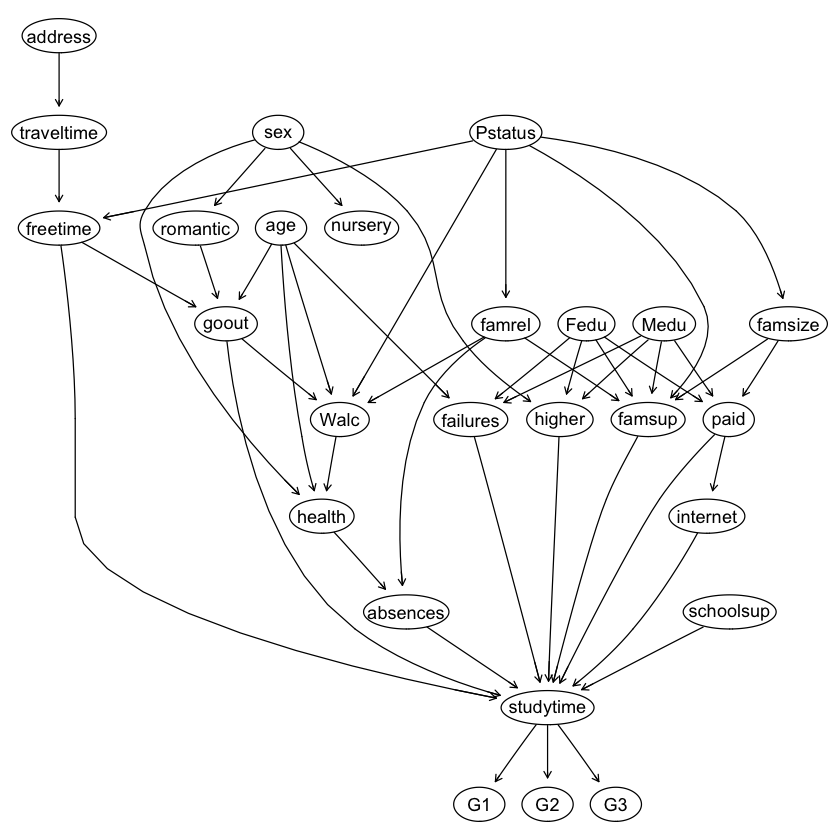

In [31]:
# ネットワーク構造を手動で決定
# 複数行に渡る場合は string 文字列をそれぞれ定義して統合する必要がある
spec1 = paste('[Medu][Fedu][address][age][sex][schoolsup][Pstatus]')
spec2 = paste('[famsize|Pstatus][traveltime|address][famrel|Pstatus]')
spec3 = paste('[failures|Medu:Fedu:age][nursery|sex][romantic|sex]')
spec4 = paste('[higher|sex:Medu:Fedu][famsup|Pstatus:Medu:Fedu:famsize:famrel]')
spec5 = paste('[paid|Medu:Fedu:famsize][freetime|Pstatus:traveltime]')
spec6 = paste('[internet|paid][goout|freetime:age:romantic]')
spec7 = paste('[Walc|age:Pstatus:famrel:goout][health|sex:age:Walc]')
spec8 = paste('[absences|famrel:health][studytime|schoolsup:failures:higher:famsup:freetime:paid:goout:absences:internet]')
spec9 = paste('[G1|studytime][G2|studytime][G3|studytime]')
spec.handmade = paste(spec1, spec2, spec3, spec4, spec5, spec6, spec7, spec8, spec9, sep = '')

# string 変数を network 変数に変換
net.handmade = model2network(spec.handmade)

# オブジェクトのクラスを表示
class(net.handmade)

# ネットワークを表示
p <- graphviz.plot(net.handmade, shape = "ellipse")

# グラフを保存
Rgraphviz::toFile(agopen(p, 'test'), 'dot', '../result/171228_Bayesian_Network_handmade.dot', 'dot')

コマンドプロンプト上で以下のコマンドを記述すれば，dot ファイルを png ファイルに変換できる．

```bash
dot -Tpng result/171228_Bayesian_Network_handmade.dot -o plot/171228_Bayesian_Network_handmade.png
```

ハンドメイド構造で学習させてみる

In [48]:
# 最尤法（MLE）で条件付き確率学習
fit.handmade = bn.fit(net.handmade, train.set, method = "mle")

# テストセットのコピーを作成
test.set2 <- test.set

# テストセットの推定したい変数の初期値を0にしておく
test.set2$Walc <- 0

# Walc を予測させてみる
pred.handmade = predict(fit.handmade, "Walc", test.set2)

# サマリーを表示
summary(pred.handmade)

# RMSE を表示
cat('RMSE :', Metrics::rmse(pred.handmade, test.set$Walc))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.070   1.844   2.230   2.263   2.674   3.483 

RMSE : 1.179166

メモ
- 見てわかるように，実際のデータは５段階なのに float 値で学習させてしまっている．
- クラス分類問題と考えたら，one-hot 表現にして，argmax を取るべきであろう．
- しかし，one-hot 表現を考えている時点で，クラス分類問題にベイジアンネットワークは向いていないのかもしれない．
- なので，これ以後の議論はまあ今後使うことがあったときのために書いているだけで，クラス分類問題と全く考えていないことに注意されたい．

## ネットワーク構造を自動で推定させる

NULL

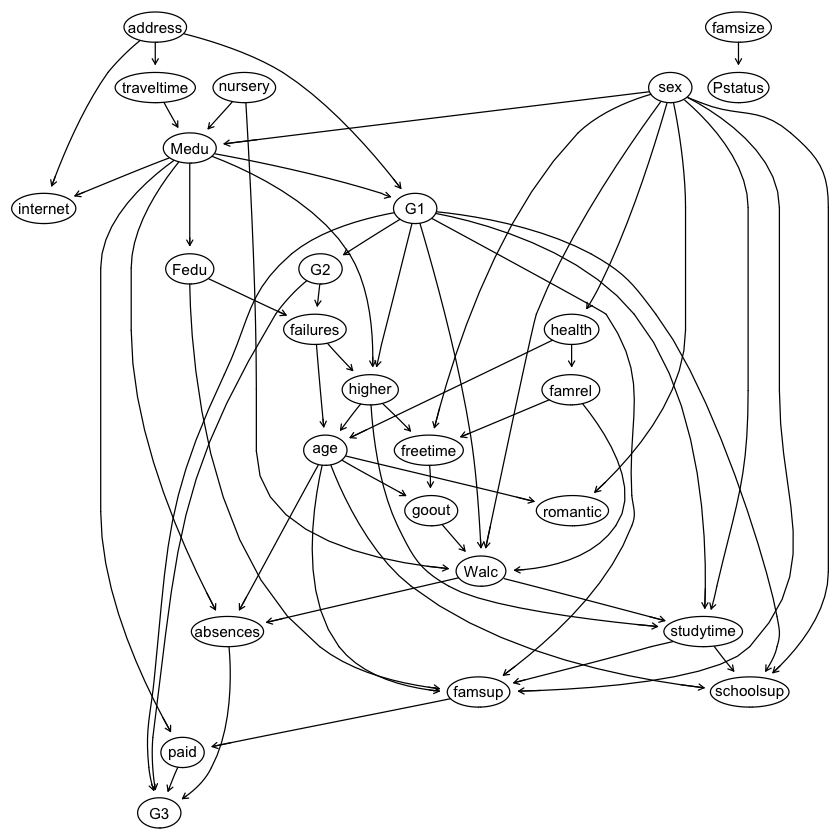

In [53]:
# ブラックリストの作成
bl = matrix(c("Walc", "sex", "G1", "sex","paid","sex"), ncol = 2, byrow = TRUE)

# ネットワーク構造の推定
net.estimated = hc(train.set, blacklist = bl)

# ネットワークを表示
p <- graphviz.plot(net.estimated, shape = "ellipse")

# グラフを保存
Rgraphviz::toFile(agopen(p, 'test'), 'dot', '../result/171228_Bayesian_Network_estimated.dot', 'dot')

In [55]:
# 最尤法（MLE）で条件付き確率学習
# ネットワーク構造を学習させたデータと同じデータで条件付き確率も学習させている（本来良くない）
fit.estimated = bn.fit(net.estimated, train.set, method = "mle")

# テストセットのコピーを作成
test.set2 <- test.set

# テストセットの推定したい変数の初期値を0にしておく
test.set2$Walc <- 0

# Walc を予測させてみる
pred.estimated = predict(fit.estimated, "Walc", test.set2)

# サマリーを表示
summary(pred.estimated)

# RMSE を表示
cat('RMSE :', Metrics::rmse(pred.estimated, test.set$Walc))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8653  1.7650  2.2710  2.2850  2.7380  4.1600 

RMSE : 1.108107

- RMSE 減ったよ，万歳．笑
- 設定上色々問題があるから，万歳でもないけどw

どれどれプロットしてみよう

pdf 
  2

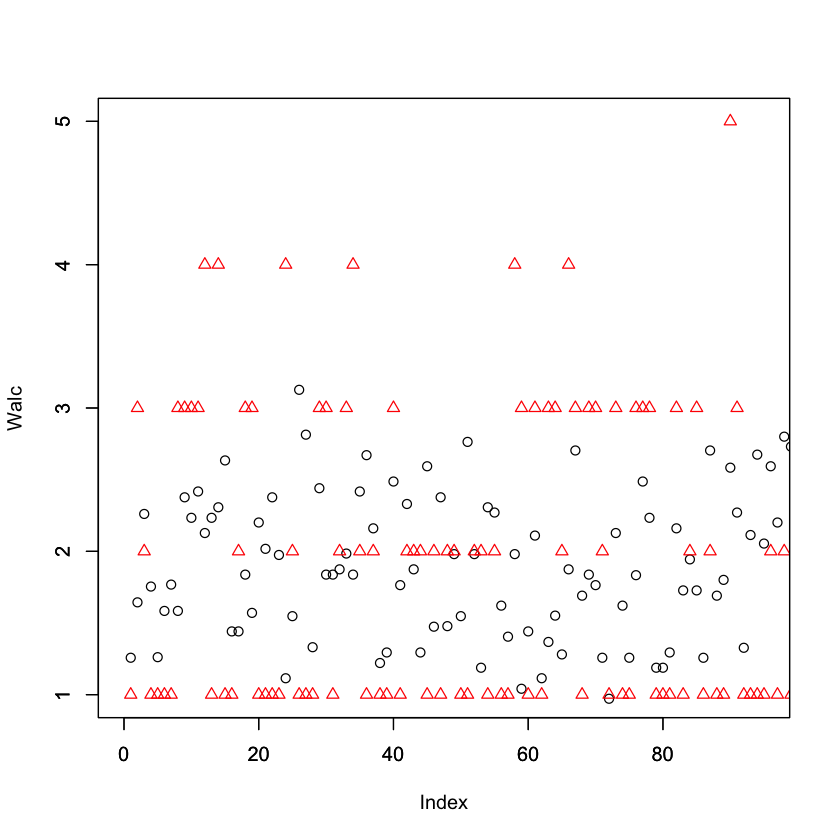

In [67]:
# png 形式の描画デバイスを開く
png("../plot/171228_Bayesian_Network_estimated_Walc.png")

# プロット
plot(pred.estimated, xlim = c(0,95), ylim = c(1,5), xlab = ' ', ylab = ' ')
par(new = T)

# 観測値は赤三角でプロット
plot(test.set$Walc, col = 'red', pch = 2, xlim = c(0,95), ylim = c(1,5), xlab = 'Index', ylab = 'Walc')

# 描画デバイスを閉じる
dev.off()

# この画面上へのプロット用
# プロット
plot(pred.estimated, xlim = c(0,95), ylim = c(1,5), xlab = ' ', ylab = ' ')
par(new = T)

# 観測値は赤三角でプロット
plot(test.set$Walc, col = 'red', pch = 2, xlim = c(0,95), ylim = c(1,5), xlab = 'Index', ylab = 'Walc')

メモ
- 保存しつつ描画というのがしにくいのが plot の欠点
- やっぱ R 使うなら ggplot だろうと思ってしまう
- まあこんな感じかなあ．次ベイジアンネットワークやることあったら Python 使いそう...笑